In [1]:
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt

from typing import Optional, Sequence, Tuple, Union, Callable, Dict, Any, TypedDict

import inspect

In [3]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

In [4]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import and inspect the data

In [5]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [6]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.unsqueeze(dim=1).float()
print('\nTensor data:')
print(images.shape)

print('\nTarget data:')
print(torch.unique(cdata.targets))

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])

Target data:
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])


In [7]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

###
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

In [8]:
# Normalizing images

images /= torch.max(images)

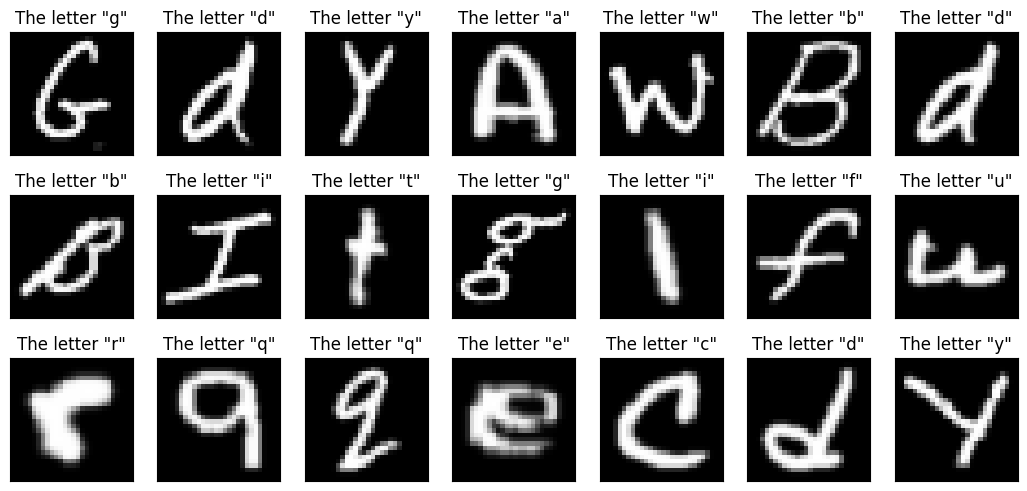

In [9]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create train/test groups using DataLoader

In [10]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [11]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [24]:
# -----------------------------Helper Functions---------------------#
def _pair(x):
    return x if isinstance(x, (tuple, list)) else (x, x)


def _get_activation(name_or_fn: Union[str, Callable[[], nn.Module], nn.Module, type]) -> nn.Module:
    """
    Build an activation module safely from:
      - string name ("relu", "gelu", "silu", etc.)
      - a no-arg factory function returning an nn.Module
      - an nn.Module subclass (class object) like nn.ReLU
      - an existing nn.Module instance (will be deep-copied to avoid sharing)
    """

    # check if the parameter passed is a singleton list
    if isinstance(name_or_fn, list):
      if len(name_or_fn) == 0:
        return None
      elif len(name_or_fn) == 1:
        return _get_activation(name_or_fn[0])
      return name_or_fn

    # Existing module instance -> deep copy (avoid shared registration)
    if isinstance(name_or_fn, nn.Module):
        return copy.deepcopy(name_or_fn)

    # Activation class (subclass of nn.Module)
    if isinstance(name_or_fn, type) and issubclass(name_or_fn, nn.Module):
        return name_or_fn()

    # Callable factory (not a class) -> call and expect an nn.Module
    if callable(name_or_fn) and not isinstance(name_or_fn, type):
        mod = name_or_fn()
        if not isinstance(mod, nn.Module):
            raise TypeError("Activation factory must return an nn.Module.")
        return mod

    # String names
    name = (name_or_fn or "leaky_relu").lower()
    if name in ("relu", "relu6"):       return nn.ReLU()
    if name in ("lrelu", "leaky_relu"): return nn.LeakyReLU()
    if name in ("gelu",):               return nn.GELU()
    if name in ("elu",):                return nn.ELU()
    if name in ("silu", "swish"):       return nn.SiLU()
    if name in ("tanh",):               return nn.Tanh()
    if name in ("sigmoid",):            return nn.Sigmoid()
    raise ValueError(f"Unknown activation: {name_or_fn}")


def _mk_acts(spec, n, label):
    """Validate list length and instantiate activation modules (fresh instances)."""
    if spec is None:
        return None
    if len(spec) == 1:
        spec = spec * n
    if len(spec) != n:
        raise ValueError(f"{label} length ({len(spec)}) must equal number of layers ({n}).")

    acts = []
    for a in spec:
        # If already a module, deep-copy to avoid sharing; else build
        acts.append(copy.deepcopy(a) if isinstance(a, nn.Module) else _get_activation(a))

    return acts


def _param_groups_no_decay(module: nn.Module):
    """
    Split parameters into (decay, no_decay) groups:
      - no weight decay for bias terms and normalization layers
      - 1D params (e.g., LayerNorm scales) -> no decay
    """
    decay, no_decay = [], []
    for name, p in module.named_parameters():
        if not p.requires_grad:
            continue
        if name.endswith(".bias") or "bn" in name.lower() or "norm" in name.lower():
            no_decay.append(p)
        else:
            (no_decay if p.ndim == 1 else decay).append(p)
    return decay, no_decay


def _init_weights_default(m: nn.Module):
    """He/Kaiming for conv, Xavier for linear, BN weight=1 bias=0."""
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        if m.weight is not None:
            nn.init.ones_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def make_optimizer(
    net: nn.Module,
    name: str = "adamw",
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    **kw: Any
) -> torch.optim.Optimizer:
    """
    Generic optimizer factory with sensible param groups.
    Supported: adamw, adam, sgd, rmsprop
    """
    decay, no_decay = _param_groups_no_decay(net)
    params = [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]
    name = name.lower()
    if name == "adamw":
        return torch.optim.AdamW(params, lr=lr, **kw)
    if name == "adam":
        return torch.optim.Adam(params, lr=lr, **kw)
    if name == "sgd":
        # default momentum if not provided
        kw.setdefault("momentum", 0.9)
        kw.setdefault("nesterov", True)
        return torch.optim.SGD(params, lr=lr, **kw)
    if name == "rmsprop":
        kw.setdefault("momentum", 0.9)
        kw.setdefault("alpha", 0.99)
        return torch.optim.RMSprop(params, lr=lr, **kw)
    raise ValueError(f"Unknown optimizer: {name}")

In [26]:
# ----------------------------- model factory -----------------------------

def makeTheNet(
    # Convolutional stack
    in_channels: int = 1,
    out_channels: Optional[Sequence[int]] = None,  # conv channel progression
    kernel_size: Union[int, Tuple[int, int]] = 3,
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Optional[Union[int, Tuple[int, int]]] = 1,
    pool_size: Optional[Tuple[int, int]] = (2, 2),
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = "zeros",
    cv_dropout: float = 0.0,
    use_conv_batchnorm: Optional[bool] = None,  # if None -> use_batchnorm

    # Fully-connected stack
    uLinear: Optional[Sequence[int]] = None,
    use_fc_batchnorm: Optional[bool] = None,    # if None -> use_batchnorm
    out_size: int = 26,
    fc_dropout: float = 0.0, # Dropout for FC Layer

    # Global toggles
    use_batchnorm: bool = False,                # default used if per-stack flags are None

    # Activations (single for all layers OR per-layer lists)
    conv_activation: Union[str, Callable[[], nn.Module], nn.Module, type] = "leaky_relu",
    fc_activation:   Union[str, Callable[[], nn.Module], nn.Module, type] = "leaky_relu",
    conv_activations: Optional[Sequence[Union[str, Callable[[], nn.Module], nn.Module, type]]] = None,
    fc_activations:   Optional[Sequence[Union[str, Callable[[], nn.Module], nn.Module, type]]] = None,

    # Regularization
    weight_decay: float = 0.0,

    # Initialization
    init_weights: bool = True,

    # Optimizer options
    optimizer_name: str = "adamw",
    lr: float = 1e-3,
    optimizer_kwargs: Optional[Dict[str, Any]] = None,

    # Device / dtype handling
    device=None,
    dtype=None,

    # Debug
    printtoggle: bool = False
):
    # Safe defaults for mutable args
    out_channels = list(out_channels) if out_channels is not None else [6, 6]
    uLinear      = list(uLinear)      if uLinear is not None else [50]

    if len(out_channels) == 0:
        raise ValueError("out_channels must contain at least one conv layer.")

    # Canonicalize pairs
    kH, kW       = _pair(kernel_size)
    sH, sW       = _pair(stride)
    pH, pW       = _pair(padding if padding is not None else 0)
    dH, dW       = _pair(dilation)
    poolH, poolW = _pair(pool_size if pool_size is not None else (1, 1))

    # Resolve BN toggles
    use_conv_bn = use_batchnorm if use_conv_batchnorm is None else use_conv_batchnorm
    use_fc_bn   = use_batchnorm if use_fc_batchnorm   is None else use_fc_batchnorm


    n_conv = len(out_channels)

    _mk_acts(conv_activations, n_conv, "conv_activations")

    class EmnistNet(nn.Module):

      def __init__(self):
          super().__init__()
          self.print = printtoggle

          # ---- Convolutional stack ----
          self.conv_blocks = nn.ModuleList()
          cin = in_channels
          n_conv = len(out_channels)

          # Fresh activation instances per conv layer
          conv_acts_list = (
              _mk_acts(conv_activations, n_conv, "conv_activations")
              if conv_activations is not None
              else [_get_activation(conv_activation) for _ in range(n_conv)]
          )

          for i, cout in enumerate(out_channels):
              if groups != 1 and (cin % groups != 0 or cout % groups != 0):
                  raise ValueError(
                      f"groups={groups} must divide in_channels={cin} and out_channels={cout}"
                  )

              use_bias = bias if not use_conv_bn else False
              conv = nn.Conv2d(
                  in_channels=cin, out_channels=cout,
                  kernel_size=_pair(kernel_size), stride=_pair(stride),
                  padding=_pair(padding if padding is not None else 0),
                  dilation=_pair(dilation), groups=groups, bias=use_bias,
                  padding_mode=padding_mode
              )
              layers = [conv]
              if use_conv_bn:
                  layers.append(nn.BatchNorm2d(cout))
              layers.append(conv_acts_list[i])
              if pool_size is not None:
                  layers.append(nn.MaxPool2d(kernel_size=_pair(pool_size)))
              if cv_dropout and cv_dropout > 0:
                  layers.append(nn.Dropout2d(p=cv_dropout))

              self.conv_blocks.append(nn.Sequential(*layers))
              cin = cout

          # Global Average Pooling → [B, C, 1, 1]
          self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

          # ---- Fully connected stack ----
          fc_in = out_channels[-1]  # after GAP, features = channels only
          self.fcs = nn.ModuleList()
          self.fcs_bn = nn.ModuleList() if use_fc_bn else None

          # Fresh activation instances per FC layer
          fc_acts_list = (
              _mk_acts(fc_activations, len(uLinear), "fc_activations")
              if fc_activations is not None
              else [_get_activation(fc_activation) for _ in range(len(uLinear))]
          )
          self.fc_act = nn.ModuleList(fc_acts_list)

          prev = fc_in
          for i, h in enumerate(uLinear):
              self.fcs.append(nn.Linear(prev, h, bias=True))
              if use_fc_bn:
                  self.fcs_bn.append(nn.BatchNorm1d(h))
              prev = h

          self.output_layer = nn.Linear(prev, out_size)
          self.fc_drop = nn.Dropout(p=fc_dropout) if fc_dropout and fc_dropout > 0 else None

          if init_weights:
              self.apply(_init_weights_default)

      def forward(self, x):
          if self.print: print("Input:", list(x.shape))

          for i, block in enumerate(self.conv_blocks):
              x = block(x)
              if self.print: print(f"Conv block {i+1}:", list(x.shape))

          x = self.global_pool(x)        # [B, C, 1, 1]
          x = torch.flatten(x, 1)        # [B, C]
          if self.print: print("After GAP:", list(x.shape))

          for i, fc in enumerate(self.fcs):
              x = fc(x)
              if self.fcs_bn is not None:
                  x = self.fcs_bn[i](x)
              x = self.fc_act[i](x)      # <-- activation applied at runtime (correct place)
              if self.fc_drop is not None:
                  x = self.fc_drop(x)

          if self.print and len(self.fcs) > 0:
              print("After FCs:", list(x.shape))

          x = self.output_layer(x)       # logits
          if self.print: print("Logits:", list(x.shape))
          return x


    # Build model
    net = EmnistNet()

    # Move to device/dtype once (constructor kwargs are version-fragile)
    if device is not None or dtype is not None:
        net = net.to(device=device, dtype=dtype)

    # Loss
    lossfun = nn.CrossEntropyLoss()

    # Optimizer (choose any of: adamw/adam/sgd/rmsprop)
    optimizer = make_optimizer(
        net,
        name=optimizer_name,
        lr=lr,
        weight_decay=weight_decay,
        **(optimizer_kwargs or {})
    )

    return net, lossfun, optimizer

# -------------------End model factory-------------------------------#

# Create a function that trains the model

In [31]:
# a function that trains the model

def function2trainTheModel( numepochs: int,
                            in_channels = 1,
                            out_channels = (6,6),
                            kernel_size = 3,
                            stride = 1,
                            cv_dropout = 0.0,
                            use_conv_batchnorm = False,
                            uLinear = [50],
                            use_fc_batchnorm = False,
                            out_size = 26,
                            fc_dropout = 0.0,
                            use_batchnorm = False,
                            conv_activation = ['leaky_relu'],
                            fc_activation = 'leaky_relu',
                            conv_activations = ['leaky_relu','Sigmoid'],
                            fc_activations = ['leaky_relu'],
                            weight_decay = 0,
                            init_weights = 0,
                            optimizer_name = 'AdamW',
                            lr = 0.001,
                            printtoggle = False
                          ):

  # create a new model
  net, lossfun, optimizer = makeTheNet(
                            in_channels = in_channels,
                            out_channels = out_channels,
                            kernel_size = kernel_size,
                            stride = stride,
                            cv_dropout = cv_dropout,
                            use_conv_batchnorm = use_conv_batchnorm,
                            uLinear = uLinear,
                            use_fc_batchnorm = use_fc_batchnorm,
                            out_size = out_size,
                            fc_dropout = fc_dropout,
                            use_batchnorm = use_batchnorm,
                            conv_activation = conv_activation,
                            fc_activation = fc_activation,
                            conv_activations = conv_activations,
                            fc_activations = fc_activations,
                            weight_decay = weight_decay,
                            init_weights = init_weights,
                            optimizer_name = optimizer_name,
                            lr = lr,
                            printtoggle = printtoggle
                        )


  # # send the model to the GPU
  net.to(device)

  # # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [32]:
# args =  {'use_batchnorm': False, 'fc_dropout': 0.0}
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(10)

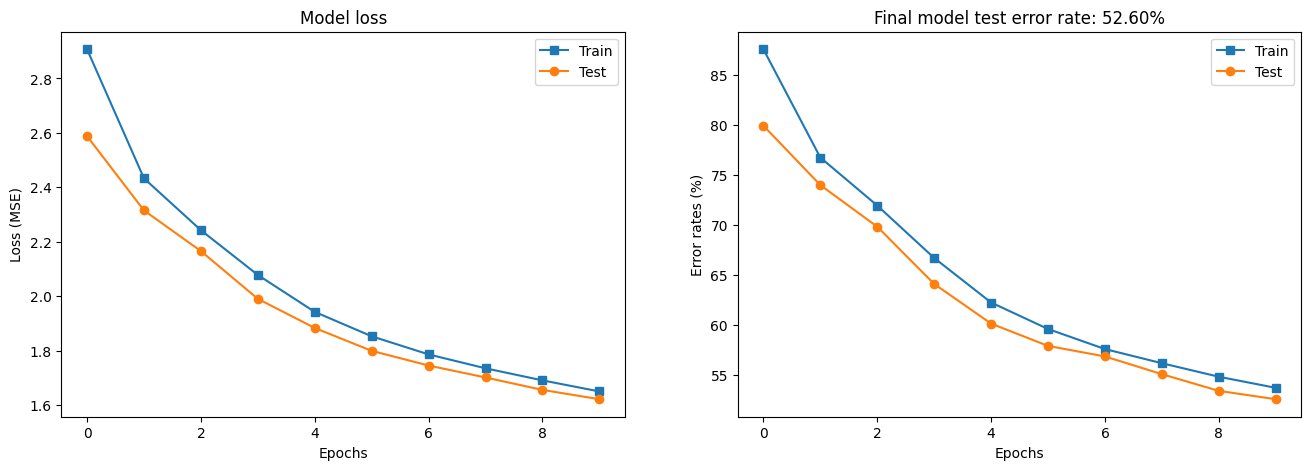

In [33]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

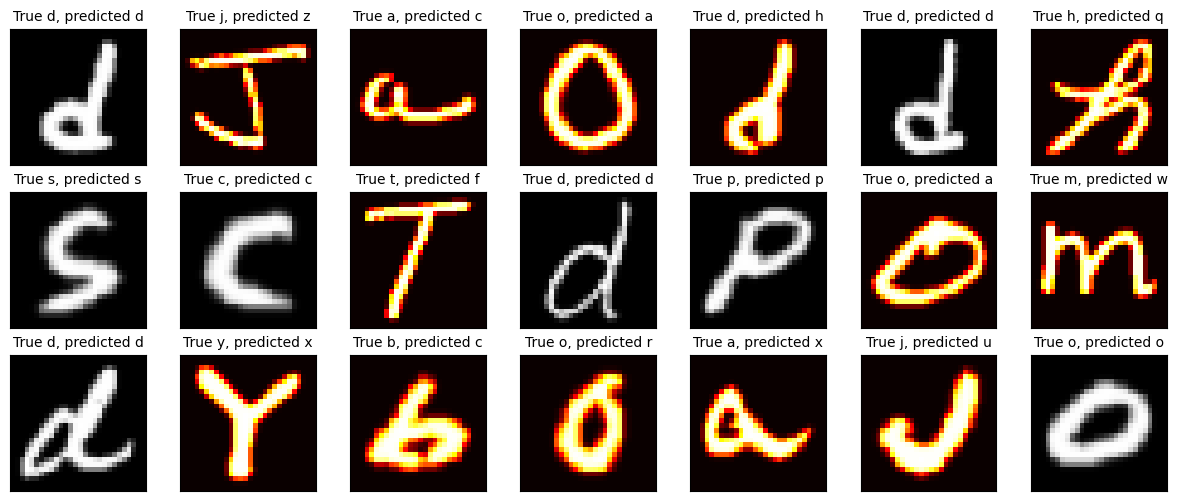

In [34]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU

# Ensure the model is on the correct device
net = net.to(device)

yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]

  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'

  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Accuracy by letter

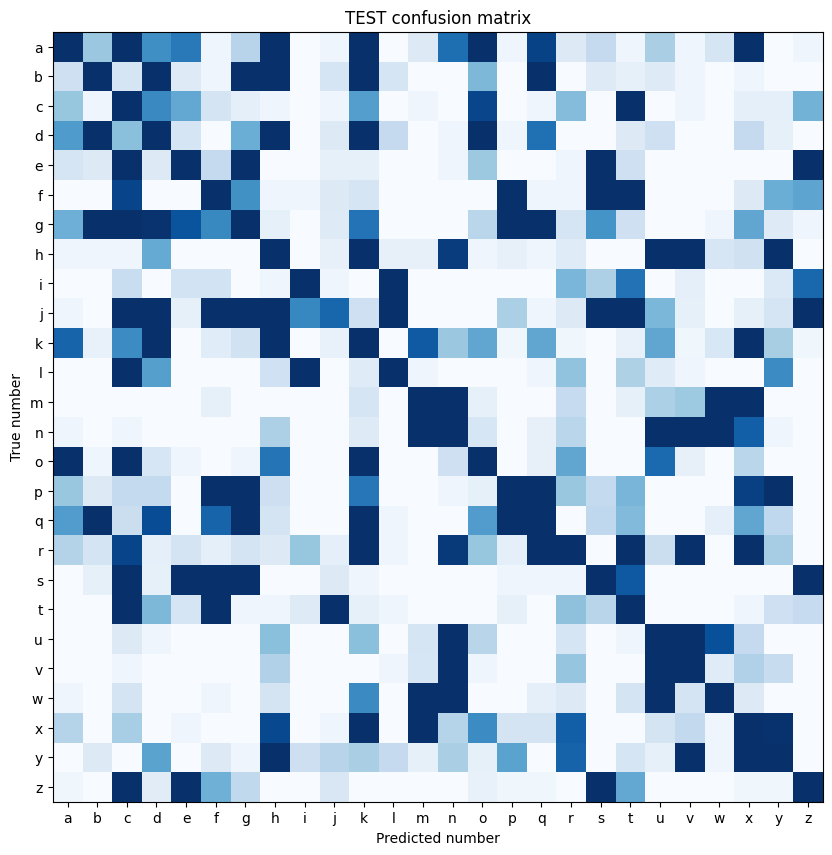

In [35]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()

EmnistNet(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Sigmoid()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fcs): ModuleList(
    (0): Linear(in_features=6, out_features=50, bias=True)
  )
  (fc_act): ModuleList(
    (0): LeakyReLU(negative_slope=0.01)
  )
  (output_layer): Linear(in_features=50, out_features=26, bias=True)
)